# Data Generation

 Create labeled training and validation data using ImageNet images.
 
 - Positive examples: manually select 10 food related synsets for food images.    
 - Negative examples: randomly sample all synsets, excluding the manually selected synsets above plus some additional food related sysnets, for non food images.
 
 Hold out data consists of two manually selected classes (not food and visually unappealing food) from wellio recipe image data. The image URLs can be found in `not_food_images.txt` and `ugly_food_images.txt` (saved in the GCS bucket with the final images mentioned below) and were downloaded with wget similarly to the below steps.

Steps below to reproduce: 
- Bash commands to generate lists of image urls, download images from those urls, check and delete duplicates
- Python to validate image files/sizes and create training and validation directories to be used with Keras [image preprocessing](https://keras.io/preprocessing/image/) (see `ImageDataGenerator.flow_from_directory()`).

Caveats:
- The non food image data contains some food images. This is because I randomly sample all synsets and then remove only *some* food related synsets to get a list of "non food" synsets (and then get image urls). As of right now, I don't know of a good way to remove all food related synsets. However, we could manually select X number of non food synsets to keep this data free of food images.
- Similar to the non food image data, the food image data contains some images that are not quite of food per se. For example, an image of a group of people sitting around a table eating dinner or an image of a bag of doritos. Also the food image data contains several low quality food images, which includes food images with text overlay.  

The final images can be found in this bucket on GCS: [kadaif.getwellio.com /kadaif/datasets/search/relevance/](https://console.cloud.google.com/storage/browser/kadaif.getwellio.com/kadaif/datasets/search/relevance/imagenet-food-not-food/?project=wellio-kadaif)

### Select 10 food related synsets 
Sample from these to get our *food images*.

1. Food:
http://www.image-net.org/synset?wnid=n00021265

2. Smoothie:
http://www.image-net.org/synset?wnid=n07914271

3. Breakfast:
http://www.image-net.org/synset?wnid=n07574602

4. Brunch:
http://www.image-net.org/synset?wnid=n07574923

5. Lunch:
http://www.image-net.org/synset?wnid=n07575076

6. Snack food:
http://www.image-net.org/synset?wnid=n07712382

7. Appetizer:
http://www.image-net.org/synset?wnid=n07581346

8. Supper:
http://www.image-net.org/synset?wnid=n07575984

9. Dinner:
http://www.image-net.org/synset?wnid=n07575726

10. Dessert:
http://www.image-net.org/synset?wnid=n07609840


In [1]:
! cat synsets_ids/ten_food_sysnets.txt

n00021265
n07574923
n07574602
n07575076
n07575726
n07575984
n07609840
n07914271
n07581346
n07712382

### Retrieve additional food related synsets 
To remove as many food related synsets as possible from the non food synset list, I search "Food" on [ImageNet](http://www.image-net.org/), then get the associated [Wordnet IDs](http://www.image-net.org/api/text/wordnet.structure.hyponym?wnid=n00021265) (by clicking the button "Wordnet IDs" above and to right of the Treemap Visualization). I then use this list to filter out additional food related synsets from the non food synset list.

In [2]:
! cat synsets_ids/all_food_synsets.txt 

n00021265
n07938313
n07566340
n14582716
n14899328
n07560652
n07935504
n07556406
n07860629
n07572353
n14583400
n07570720
n07800091
n07556637
n01464844
n07881800

### Grab all synsets on ImageNet
Sample from these to get our *non food images.*

`curl http://www.image-net.org/api/text/imagenet.synset.obtain_synset_list > all_synsets.txt` 

### Remove food related synsets from all synsets list
Because we don't want food images in our non food image dataset.

Explanation of grep flags:     
-F: use literal strings instead of the default BRE    
-x: only consider matches that match the entire line    
-v: print non-matching    
-f file: take patterns from the given file    

(from this [stackoverlow question](https://stackoverflow.com/a/32267899)) 

`grep -Fvxf all_food_synsets.txt all_synsets.txt > non_food_synsets.txt`     
`grep -Fvxf ten_food_sysnets.txt non_food_synsets.txt > non_food_synsets.txt`

### Sample food synsets to get food image urls
For each of the 10 synsets selected above, grab the first 200 urls. The results is 2,000 food image urls.

```
for synset in $( cat synsets/food_synsets.txt )
do
    curl -s "http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=${synset}" | head -n 200  >>
    positive_training_examples_urls.txt
done 
```

### Sample non food synsets to get non food image urls

For 2,000 randomly selected non food synsets, grab the first url. The results is 2,000 non food image urls. 
```
for synset in $( cat synsets/non_food_synsets.txt | shuf | head -n 2000 )
do
    curl -s "http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=${synset}" | head -n 1  >>
    negative_training_examples_urls.txt
done
```

### Download images from urls 
Use wget to download the food and non food images from the above urls.

`wget --tries=1 -i positive_training_examples_urls.txt -P Images/Food`    

### Find duplicate images
Find duplicate files based on MD5 hashes using md5sum. 

`md5sum Images/Food/* | cut -d\   -f1 | sort | uniq -c | sort -n | tail`

### Delete duplicates

**Based on duplicate filenames:**   

`find Images/"Not Food"/* -name '*.[0-9]' -exec rm -rf {} \;`    

**Based on duplicate file content:**
```
for f in $( ls -1 Images/Food/ )
do
  m=$( md5sum "Images/Food/$f" | cut -d\  -f1 )
  if [ "$m" = "aafa26a6610d377d8e42f44bc7e76635" ]
  then
     rm -v "Images/Food/$f" 
  fi
done | wc -l
```

### Check if images are valid 
Criteria: files are images files (ie can be opened as a PIL object) and meet a 150 pixel width and height minimum.

In [3]:
! ls -l Images/"ImageNet raw"/Food | wc -l

1619


In [4]:
! ls -l Images/"ImageNet raw"/"Not Food" | wc -l

2334


In [1]:
import glob
from PIL import Image
import numpy as np
import pandas as pd
import shutil
import random
from sklearn.model_selection import train_test_split

In [6]:
def image_validator(path):
  lst = []
  for fname in glob.glob(path):
    try:
      img = Image.open(fname)
      size = np.array(img).shape
      if (size[0] >= 150) & (size[1] >= 150) & (size[2] == 3) & fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.ppm')):
        lst.append(fname)
    except IOError as e:
      pass
    except IndexError as e:
      pass 
  return lst

In [7]:
food_files = image_validator('Images/ImageNet raw/Food/*')
not_food_files = image_validator('Images/ImageNet raw/Not Food/*')

In [8]:
len(food_files), len(not_food_files)

(1592, 1853)

### Create training and validation directories 

#### Randomly sample 1600 non food images 

In [9]:
not_food_files_1600 = np.random.choice(not_food_files, 1600, replace=False)

#### Train test split 
Set test size to 400 images from both food and non food images.

In [10]:
food_train, food_val = train_test_split(food_files, test_size=400)
not_food_train, not_food_val = train_test_split(not_food_files_1600, test_size=400)

In [31]:
len(food_train)

1192

#### Copy images to train/validation directories

In [11]:
def copy_images(file_list, dest_path):
  for fname in file_list:
    shutil.copy(fname, dest_path)

In [12]:
files = [food_train, food_val, not_food_train, not_food_val]
path_list = ['Images/ImageNet clean/train/food', 'Images/ImageNet clean/validation/food', 'Images/ImageNet clean/train/not_food', 'Images/ImageNet clean/validation/not_food']

In [24]:
files = [food_train, food_val, not_food_train, not_food_val]
path_list = ['Images/ImageNet clean 2/train/food', 'Images/ImageNet clean 2/validation/food', 'Images/ImageNet clean 2/train/not_food', 'Images/ImageNet clean 2/validation/not_food']

In [25]:
for fname, path in zip(files, path_list):
  copy_images(fname, path)

After the above steps, the positive training set was left with 1192 images – I downloaded 8 images (again with wget) to round out the set to 1200. They were selected from high quality recipe sources as outline [here](https://docs.google.com/document/d/1UkQiplw9hfXbNExuQQO03A4i7hU7iOITNV6aj7NvJQA/edit) and the associated URLS can be food in `additional_food_imgs.txt`.



### Visualize images from training data

In [51]:
def show_images(lst, n):
  for f in np.random.choice(lst, n, replace=False):
    img = Image.open(f)
    if img.width > 150:
      new_w = 150
      new_h = new_w * img.height / img.width
      img = img.resize((new_w, new_h), Image.ANTIALIAS)
      display(img) 

#### Five random images from our food images

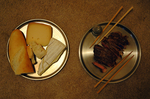

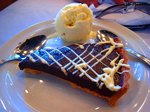

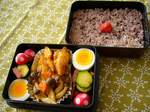

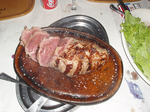

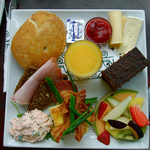

In [59]:
show_images(food_train, 5)

#### Five random images from our non food images

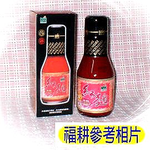

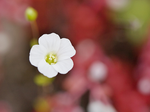

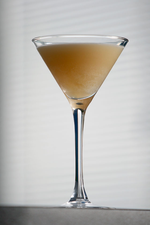

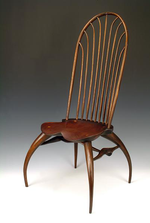

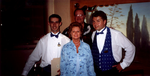

In [66]:
show_images(not_food_train, 5)

### Save images to GCS
After visually inspecting some of the trainging data to further check valid file types and also relevance to the classes of interest (food, not food), the final images were copied to [kadaif.getwellio.com /kadaif/datasets/search/relevance/](https://console.cloud.google.com/storage/browser/kadaif.getwellio.com/kadaif/datasets/search/relevance/imagenet-food-not-food/?project=wellio-kadaif)